# Scotiabank - Stock Prices Prediction

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_datareader as webreader
import pandas as pd
import tensorflow as tf
import seaborn as sns
import datetime as dt

from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data
from tensorflow import keras

## 2. Data Preprocessing and Visualization

### 2.1. Load Data

In [2]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [3]:
# Import dataset
df = pd.read_csv('BNS-Stocks-2015-2023.csv')

# today = date.today()
# date_today = today.strftime("%Y-%m-%d")
# date_start = '2015-02-03'

# # Read stock quotes from Yahoo Finance
# df = data.DataReader("BNS.TO", data_source='yahoo', start=date_start, end=date_today)
# df = webreader.DataReader('BNS.TO', data_source='yahoo', start=date_start, end=date_today)

# Input data of np array - Closing price
dataset = df.iloc[:, 4:5].values

# Dataset shape
print(dataset.shape)

(2008, 1)


### 2.2. Analyze Data

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-02-03,62.470001,64.370003,62.119999,63.840000,43.465080,2806000
1,2015-02-04,63.910000,64.370003,63.250000,63.430000,43.185932,1750000
2,2015-02-05,63.689999,64.779999,63.470001,64.599998,43.982513,1770100
3,2015-02-06,65.099998,65.900002,64.849998,65.129997,44.343365,2514600
4,2015-02-09,65.099998,66.110001,64.849998,65.470001,44.574856,1608700
...,...,...,...,...,...,...,...
2003,2023-01-27,71.260002,71.440002,70.639999,70.970001,70.970001,4858200
2004,2023-01-30,70.669998,71.099998,70.669998,71.050003,71.050003,4166500
2005,2023-01-31,71.250000,72.040001,70.989998,72.029999,72.029999,3378200
2006,2023-02-01,72.059998,72.660004,71.760002,72.349998,72.349998,3121300


In [5]:
# Brief info about dataframe - non-null values and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2008 non-null   object 
 1   Open       2008 non-null   float64
 2   High       2008 non-null   float64
 3   Low        2008 non-null   float64
 4   Close      2008 non-null   float64
 5   Adj Close  2008 non-null   float64
 6   Volume     2008 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 109.9+ KB


In [6]:
# Check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
# imputer.fit_transform(dataset)
# dataset = imputer.transform(dataset)
# df.dropna(inplace=True)

In [8]:
# Dataframe statistics on quantitative (numerical) values
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2.008000e+03
mean,71.771618,72.208292,71.301808,71.761962,59.129946,3.081755e+06
std,9.143344,9.107118,9.196607,9.146770,11.496050,2.165441e+06
min,49.139999,50.570000,46.380001,46.720001,36.961868,3.626000e+05
25%,65.279999,65.795002,64.895003,65.290001,49.469107,1.713700e+06
50%,72.820000,73.080002,72.375000,72.665001,59.192532,2.377500e+06
75%,78.202497,78.580002,77.762501,78.150002,64.073526,3.677775e+06
max,94.980003,95.000000,93.839996,94.489998,89.312477,2.099180e+07


### 2.3. Visualize Data

#### Pariwise relationship between features

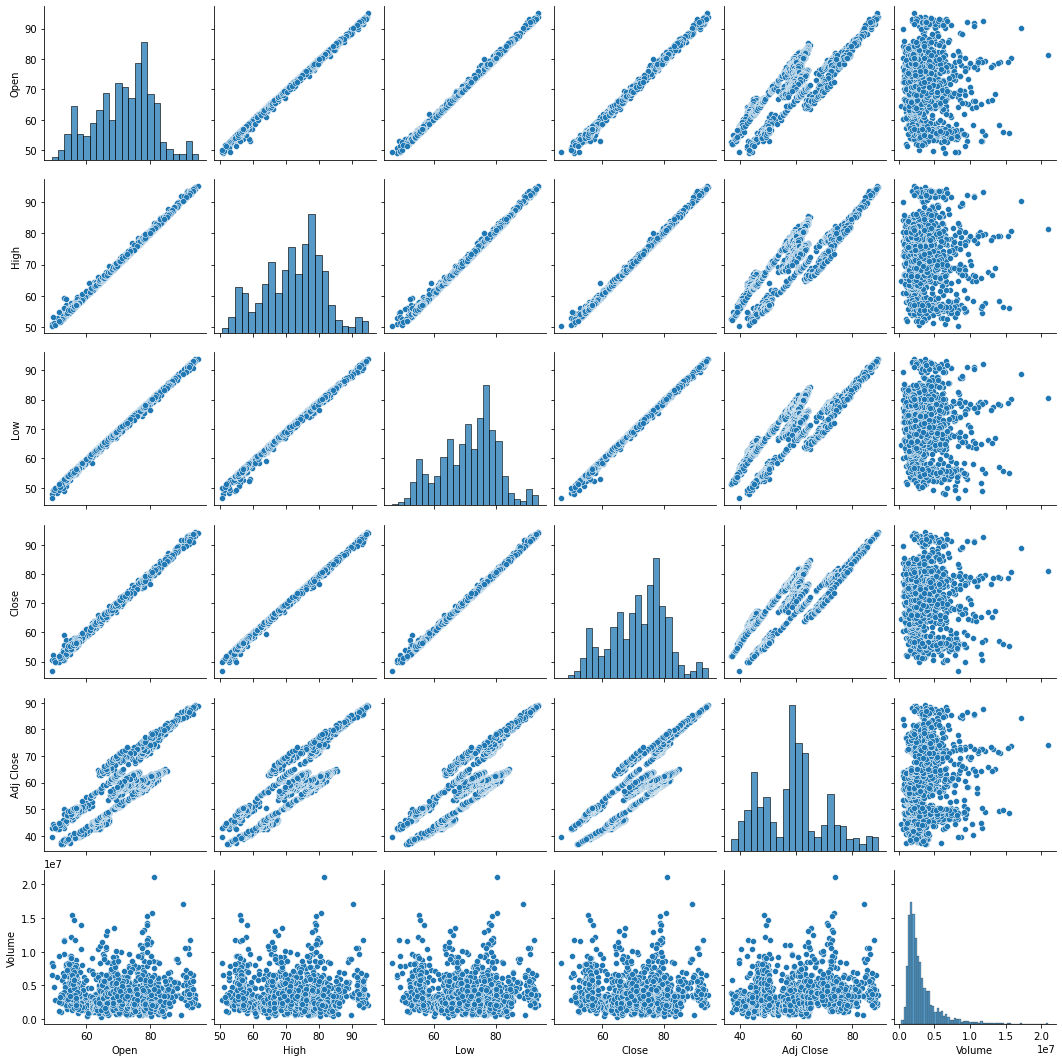

In [9]:
# Pairwise distributions
sns.pairplot(df)

# Show figure
plt.show()

#### Correlation Map

Text(0.5, 1.0, 'Correlation Map')

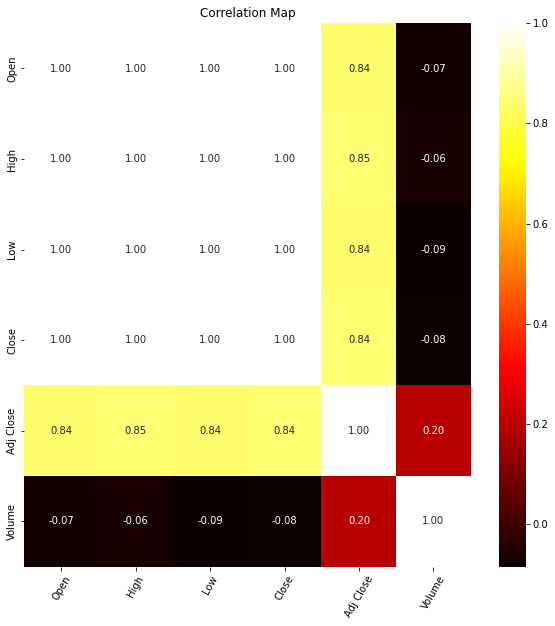

In [10]:
# Correlation Map
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='hot', fmt='.2f')
# Adjust X-Axis
plt.xticks(rotation=60)
# Plot title
plt.title('Correlation Map')

#### Individual stock prices and volume distribution

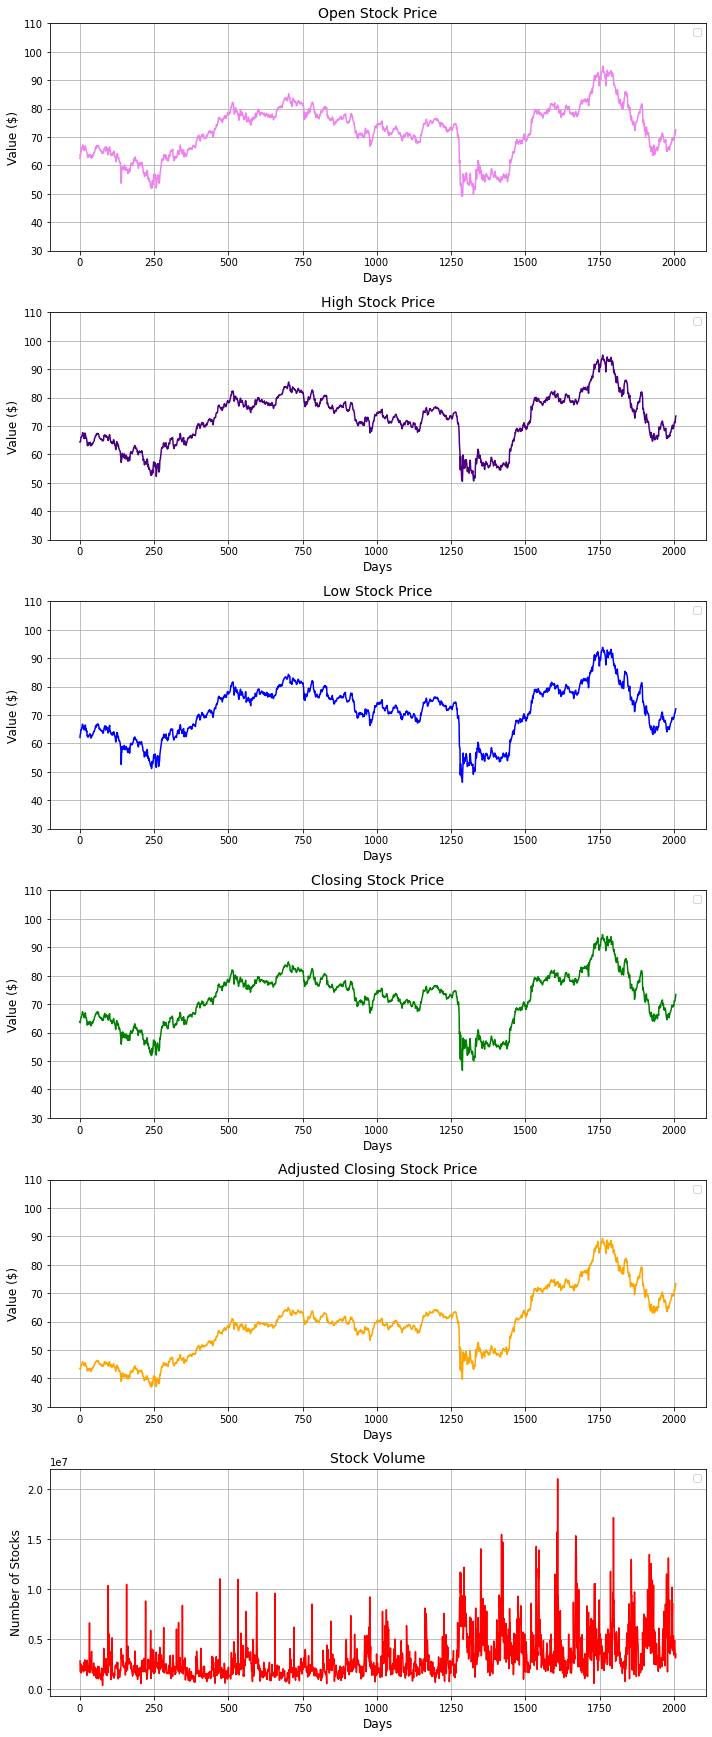

In [11]:
# Define stock prices figure
bns_stock_prices = plt.figure(figsize=(10,24))

# Open Stock Price
ax1 = bns_stock_prices.add_subplot(6, 1, 1)
ax1 = plt.plot(df['Open'], color = 'violet')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 120, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Open Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid()

# High Stock Price
ax2 = bns_stock_prices.add_subplot(6, 1, 2)
ax2 = plt.plot(df['High'], color = 'indigo')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 120, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('High Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid()

# Low Stock Price
ax3 = bns_stock_prices.add_subplot(6, 1, 3)
ax3 = plt.plot(df['Low'], color = 'blue')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 120, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Low Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid()

# Closing Stock Price (target variable)
ax4 = bns_stock_prices.add_subplot(6, 1, 4)
ax4 = plt.plot(df['Close'], color = 'green')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 120, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Closing Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid()

# Adjusting Closing Stock Price
ax5 = bns_stock_prices.add_subplot(6, 1, 5)
ax5 = plt.plot(df['Adj Close'], color = 'orange')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 120, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Adjusted Closing Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid()

# Volume (number of stocks)
ax6 = bns_stock_prices.add_subplot(6, 1, 6)
ax6 = plt.plot(df['Volume'], color = 'red')
# Adjust axes range(s)
# plt.xticks()
# plt.yticks()
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Stock Volume', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid()

# Plot each data column
# bns_stock_trends = df.plot(subplots=True, figsize=(12,20), sharex=False, cmap='rainbow')
# Plot label
# plt.xlabel('Days', fontsize=12)
# bns_stock_trends.xaxis.set_major_locator(mdates.AutoDateLocator())

# Show plot
plt.show()

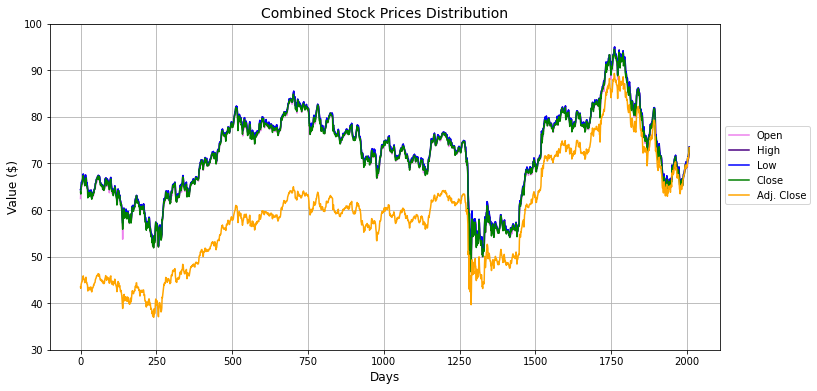

In [12]:
# Define figure
bns_stock_prices_comb = plt.figure(figsize=(12,6))

# Open Stock Price
bns_stock_prices_comb = plt.plot(df['Open'], color = 'violet', label = 'Open')
# High Stock Price
bns_stock_prices_comb = plt.plot(df['High'], color = 'indigo', label = 'High')
# Low Stock Price
bns_stock_prices_comb = plt.plot(df['High'], color = 'blue', label = 'Low')
# Closing Stock Price
bns_stock_prices_comb = plt.plot(df['Close'], color = 'green', label = 'Close')
# Adjusted Closing Stock Price
bns_stock_prices_comb = plt.plot(df['Adj Close'], color = 'orange', 
                                 label = 'Adj. Close')
# Adjust X and Y-Axes ranges
plt.yticks(np.arange(30, 110, 10))
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Combined Stock Prices Distribution', fontsize=14)
# Plot legend and grid
plt.legend(bbox_to_anchor=(1, 0.7))
plt.grid()

# Show plot
plt.show()

#### Combined distribution

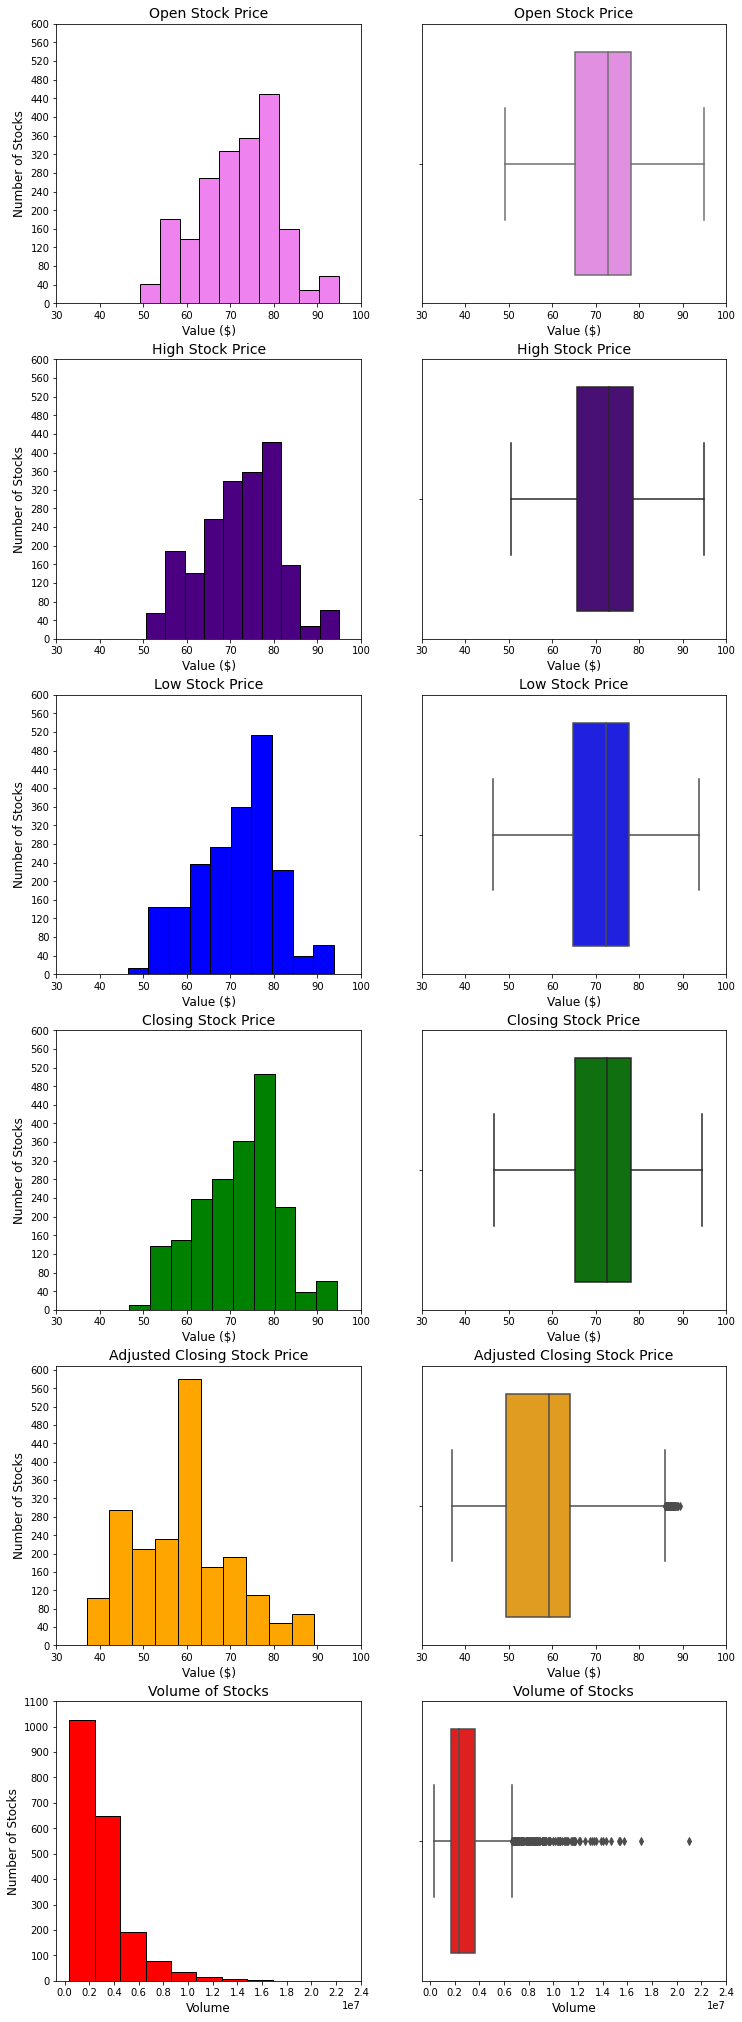

In [13]:
# Define figure
bns_comb_dist = plt.figure(figsize=(12, 36))

# -- Open Stock Prices --

# Histogram
ax1 = bns_comb_dist.add_subplot(6, 2, 1)
ax1 = plt.hist(x=df['Open'], color='violet', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 110, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Open Stock Price', fontsize=14)

# Box Plot
ax2 = bns_comb_dist.add_subplot(6, 2, 2)
ax2 = sns.boxplot(x=df['Open'], color='violet')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 110, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Open Stock Price', fontsize=14)

# -- High Stock Prices --

# Histogram
ax3 = bns_comb_dist.add_subplot(6, 2, 3)
ax3 = plt.hist(x=df['High'], color='indigo', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 110, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('High Stock Price', fontsize=14)

# Box Plot
ax4 = bns_comb_dist.add_subplot(6, 2, 4)
ax4 = sns.boxplot(x=df['High'], color='indigo')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 110, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('High Stock Price', fontsize=14)

# -- Low Stock Prices --

# Histogram
ax5 = bns_comb_dist.add_subplot(6, 2, 5)
ax5 = plt.hist(x=df['Low'], color='blue', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 110, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Low Stock Price', fontsize=14)

# Box Plot
ax6 = bns_comb_dist.add_subplot(6, 2, 6)
ax6 = sns.boxplot(x=df['Low'], color='blue')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 110, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Low Stock Price', fontsize=14)

# -- Closing Stock Prices --

# Histogram
ax7 = bns_comb_dist.add_subplot(6, 2, 7)
ax7 = plt.hist(x=df['Close'], color='green', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 110, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Closing Stock Price', fontsize=14)

# Box Plot
ax8 = bns_comb_dist.add_subplot(6, 2, 8)
ax8 = sns.boxplot(x=df['Close'], color='green')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 110, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Closing Stock Price', fontsize=14)

# -- Adjusted Closing Stock Prices --

# Histogram
ax9 = bns_comb_dist.add_subplot(6, 2, 9)
ax9 = plt.hist(x=df['Adj Close'], color='orange', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 110, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Adjusted Closing Stock Price', fontsize=14)

# Box Plot
ax10 = bns_comb_dist.add_subplot(6, 2, 10)
ax10 = sns.boxplot(x=df['Adj Close'], color='orange')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 110, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Adjusted Closing Stock Price', fontsize=14)

# -- Volume of Stocks --

# Histogram
ax11 = bns_comb_dist.add_subplot(6, 2, 11)
ax11 = plt.hist(x=df['Volume'], color='red', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(0, 26000000, 2000000))
plt.yticks(np.arange(0, 1200, 100))
# Plot title and label(s)
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Volume of Stocks', fontsize=14)

# Box Plot
ax12 = bns_comb_dist.add_subplot(6, 2, 12)
ax12 = sns.boxplot(x=df['Volume'], color='red')
# Adjust X-Axis range(s)
plt.xticks(np.arange(0, 26000000, 2000000))
# Plot title and label(s)
plt.xlabel('Volume', fontsize=12)
plt.title('Volume of Stocks', fontsize=14)

# Show subplot
plt.show()

### 2.4. Feature Engineering

In [14]:
# Normalize data
sc = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = sc.fit_transform(dataset)

In [15]:
dataset_scaled

array([[0.35838392],
       [0.34980113],
       [0.37429345],
       ...,
       [0.52983043],
       [0.53652917],
       [0.55830018]])

In [16]:
# Split dataset into training set and test set (80/20 split)
training_size = int(len(df)*0.8)
dataset_train = dataset_scaled[:training_size]
dataset_test = dataset_scaled[training_size:]

print('Training set shape: ' + str(dataset_train.shape))
print('Test set shape: ' + str(dataset_test.shape))

Training set shape: (1606, 1)
Test set shape: (402, 1)


In [17]:
# Define number of timesteps
timesteps = 60

In [18]:
# Predict stock price results using 60 timesteps (60 business days)
def define_training_data(timesteps, dataset):
  """
  timesteps - number of timesteps
  dataset   - stock prices (training) dataset
  """

  # X - number of timesteps, y - indicators (features) used for training
  X, y = [], []
  for i in range(timesteps, dataset.shape[0]):
    # Get number of timesteps (business days)
    X.append(dataset[i-timesteps:i, 0])
    # Starting date of reporting (increments during model training)
    y.append(dataset[i, 0])
  X, y = np.array(X), np.array(y)
  return X, y

X_train, y_train = define_training_data(timesteps, dataset_train)
print(X_train.shape, y_train.shape)

(1546, 60) (1546,)


In [19]:
# Reshape(number of rows, number of timesteps (columns), number of predictors)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [20]:
X_train

array([[[0.35838392],
        [0.34980113],
        [0.37429345],
        ...,
        [0.42306888],
        [0.43165159],
        [0.43039563]],

       [[0.34980113],
        [0.37429345],
        [0.38538826],
        ...,
        [0.43165159],
        [0.43039563],
        [0.4146954 ]],

       [[0.37429345],
        [0.38538826],
        [0.39250578],
        ...,
        [0.43039563],
        [0.4146954 ],
        [0.42076618]],

       ...,

       [[0.68348344],
        [0.6872515 ],
        [0.66778321],
        ...,
        [0.68348344],
        [0.69353149],
        [0.68892606]],

       [[0.6872515 ],
        [0.66778321],
        [0.67573793],
        ...,
        [0.69353149],
        [0.68892606],
        [0.69520622]],

       [[0.66778321],
        [0.67573793],
        [0.66129368],
        ...,
        [0.68892606],
        [0.69520622],
        [0.70169561]]])

In [21]:
X_train.shape

(1546, 60, 1)

## 3. Define and Evaluate LSTM model

###### **NOTE:** LSTM - Long Short-Term Memory

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

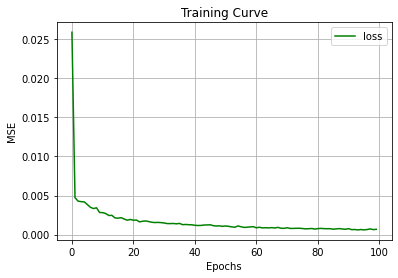

In [23]:
# Define LSTM model
reg = Sequential()

# -- LSTM layers -- 

# Input and first (hidden) layer (with dropout regularization)
reg.add(LSTM(units=60, return_sequences=True, 
             input_shape=(X_train.shape[1], X_train.shape[2])))
reg.add(Dropout(0.1))
# Additional hidden layers
reg.add(LSTM(units=60, return_sequences=True))
reg.add(Dropout(0.1))
reg.add(LSTM(units=60, return_sequences=True))
reg.add(Dropout(0.1))
reg.add(LSTM(units=60, return_sequences=False))
reg.add(Dropout(0.1))

# Output layer
reg.add(Dense(units=X_train.shape[2]))

# Compile model
reg.compile(optimizer='adam', loss='mean_squared_error')

# Summarize LSTM model
reg.summary()

# Train (fit) model
history = reg.fit(X_train, y_train, batch_size=32, epochs=100)

# Plot loss during training (Mean Squared Error - MSE)
plt.plot(history.history['loss'], 'g', label='loss')
# Plot title and labels
plt.title('Training Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
# Plot legend and grid
plt.legend()
plt.grid()

# Show loss results
plt.show()

## 6. Evalutate model

#### Make predictions

In [24]:
# Get n (number of timesteps) previous stock prices for predicting
inputs = dataset[len(dataset)-len(dataset_test) - timesteps:]
# Reshape input values
inputs = inputs.reshape(-1, 1)
# Scale input values, directly apply transformations (already fitted)
inputs = sc.transform(inputs)

# Define test set structure
X_test = []
# For the entire test set
for i in range(timesteps, timesteps + len(dataset_test)):
  # Range of values from i-60 to i, first column
  X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)

# Obtain 3D structure of the test set
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict the test set results
predicted_stock_price = reg.predict(X_test)
# Apply inverse transformations
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(dataset_test)

# Print predicted and real stock prices side-by-side (if required)
# print(np.concatenate((predicted_stock_price.reshape(len(predicted_stock_price), 1), 
#                       real_stock_price.reshape(len(real_stock_price), 1)), 1 ))

# Print Scores
print('')
print('--- Prediction Scores ---')
print('')
# Mean Absolute Error (MAE)
print('MAE: %.3f' % (mean_absolute_error(real_stock_price, predicted_stock_price)))
# Mean Squared Error (MSE)
print('MSE: %.3f' % (mean_squared_error(real_stock_price, predicted_stock_price)))
# Root Mean Squared Error (RMSE)
print('RMSE: %.3f' % (mean_squared_error(real_stock_price, predicted_stock_price, squared=False)))
# R^2 Score (Goodness-of-Fit)
print('R^2 Score: %.3f%%' % (r2_score(real_stock_price, predicted_stock_price) * 100))

13/13 [==============================] - 2s 31ms/step

--- Prediction Scores ---

MAE: 0.749
MSE: 0.942
RMSE: 0.970
R^2 Score: 98.628%


#### Visualize Prediction Results

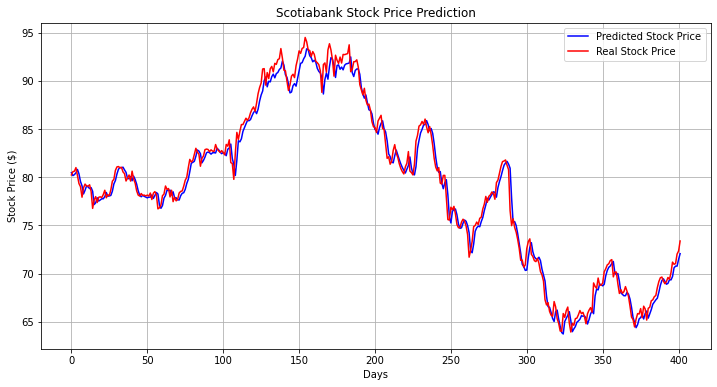

In [25]:
# Define results figure
bns_results = plt.figure(figsize=(12,6))

# Plot results
bns_results = plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
bns_results = plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
# Plot title and labels
plt.xlabel('Days')
plt.ylabel('Stock Price ($)')
plt.title('Scotiabank Stock Price Prediction')
# Plot legend and grid
plt.legend()
plt.grid()

# Show plot
plt.show()

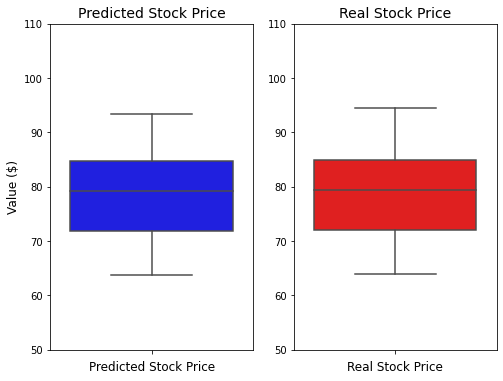

In [26]:
# Combined box plot distributions
box_plots_comb = plt.figure(figsize=(8, 6))

# Box plot for lr_pred
ax1 = box_plots_comb.add_subplot(1, 2, 1)
ax1 = sns.boxplot(y=predicted_stock_price, color='blue', orient='v')
# Adjust Y-Axis Range
plt.yticks(np.arange(50, 120, 10))
# Plot title and labels
plt.xlabel('Predicted Stock Price', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Predicted Stock Price', fontsize=14)

# Box plot for linear_svr_pred
ax2 = box_plots_comb.add_subplot(1, 2, 2)
ax2 = sns.boxplot(y=real_stock_price, color='red', orient='v')
# Adjust Y-Axis Range
plt.yticks(np.arange(50, 120, 10))
# Plot title and label
plt.xlabel('Real Stock Price', fontsize=12)
plt.title('Real Stock Price', fontsize=14)

# Show subplot
plt.show()